In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai.vision import *
from fastai.conv_learner import *
from fastai.metrics import error_rate
from fastai import *
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random

ModuleNotFoundError: No module named 'fastai.conv_learner'

In [8]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [9]:
def save_train_data(fnames, labels, bboxes):
    src_folder ='//home//jupyter//ai-for-sea//data//cars_train//'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))

        if i in train_indexes:
            dst_folder = '//home//jupyter//ai-for-sea//data//train//'
        else:
            dst_folder = '//home//jupyter//ai-for-sea//data//valid//'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [10]:
def save_test_data(fnames, bboxes):
    src_folder = '//home//jupyter//ai-for-sea//data//cars_test//'
    dst_folder = '//home//jupyter//ai-for-sea//data//test//'
    num_samples = len(fnames)

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [11]:
def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('//home//jupyter//ai-for-sea//data//devkit//cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)

In [12]:
def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('//home//jupyter//ai-for-sea//data//devkit//cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

In [13]:
img_width, img_height = 224, 224

In [14]:
os.path.exists('data/cars_train')

True

In [15]:
cars_meta = scipy.io.loadmat('data/devkit/cars_meta')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]


In [16]:
ensure_folder('//home//jupyter//ai-for-sea//data/train')
ensure_folder('//home//jupyter//ai-for-sea//data/valid')
ensure_folder('//home//jupyter//ai-for-sea//data/test')

In [17]:
process_train_data()

Processing train data...
[  1   2   3   4 ... 193 194 195 196]
The number of different cars is 196


In [18]:
process_test_data()

Processing test data...


In [3]:
data = ImageDataBunch.from_folder('data/','train','valid',ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),size=224,bs=32).normalize(imagenet_stats)

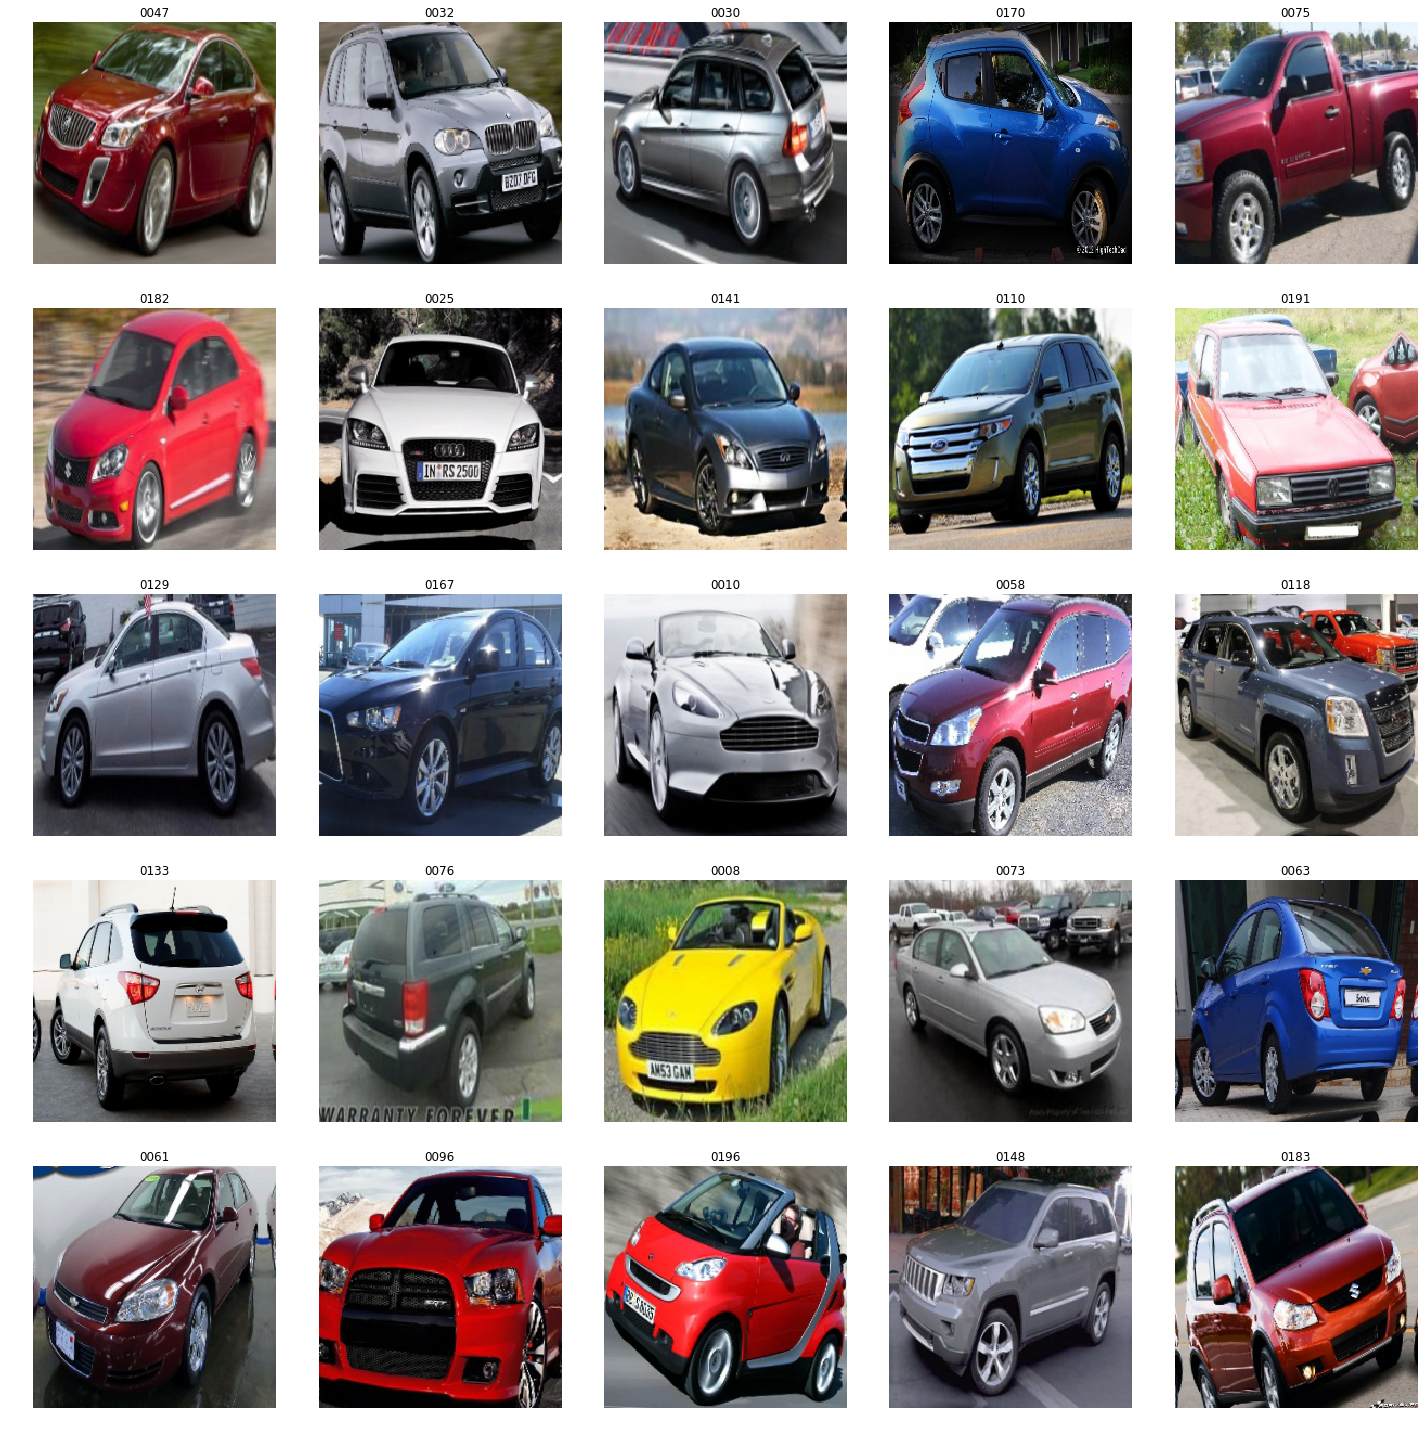

In [4]:
data.show_batch()

In [5]:
# class names and number of classes
# print(data.classes)
len(data.classes), data.c

(196, 196)

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

In [9]:
ConvLearner.pretrained??

Object `ConvLearner.pretrained` not found.


In [8]:
learn.opt_fn

AttributeError: 'Learner' object has no attribute 'opt_fn'

In [23]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,4.336446,3.416677,0.232658,01:12
1,2.721038,2.068076,0.495396,01:06
2,1.733368,1.604880,0.579497,01:06
3,1.149875,1.489637,0.620626,01:07


In [24]:
preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0}.'.format(acc))

The accuracy is 0.6206261515617371.


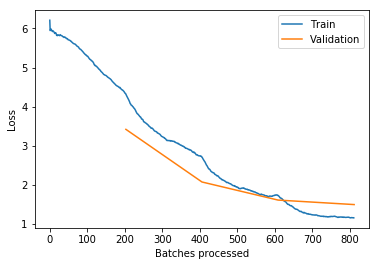

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('cv-cars-resnet50-1')

In [27]:
# RESULTS
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

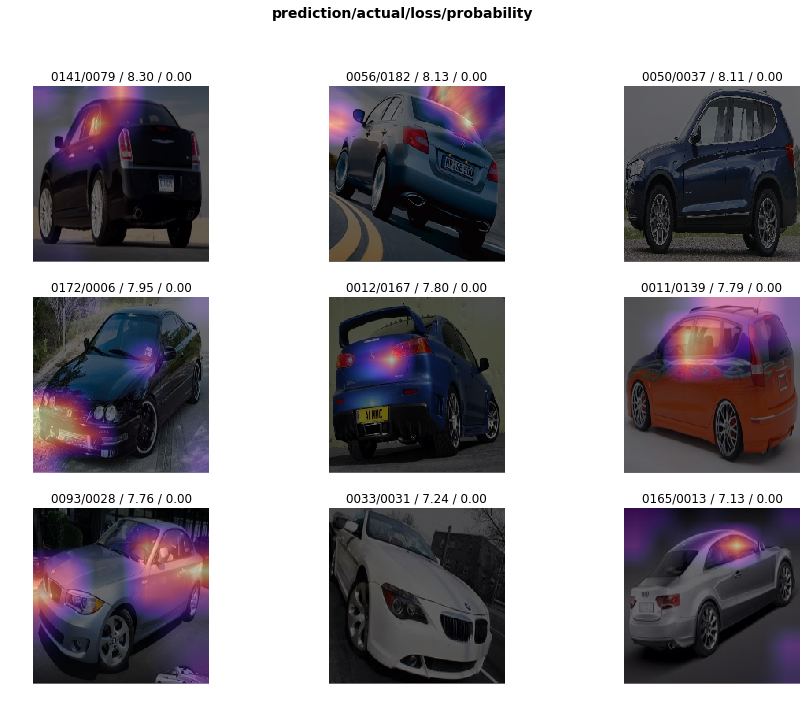

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


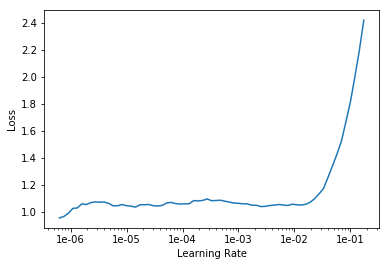

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.005232,1.338023,0.659914,01:30
1,0.863187,1.134532,0.697360,01:29
2,0.762689,1.031230,0.728668,01:29
3,0.645364,0.904286,0.750153,01:29
4,0.542899,0.866340,0.760589,01:29
5,0.376158,0.816094,0.767342,01:29
6,0.289249,0.821621,0.782689,01:29
7,0.224257,0.682430,0.808471,01:29
8,0.153550,0.694913,0.819521,01:29
9,0.110865,0.604210,0.847759,01:29


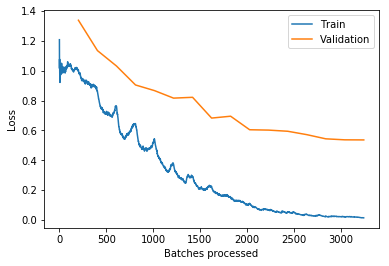

In [27]:
learn.recorder.plot_losses()

In [29]:
learn.save('cv-cars-resnet50-2')

## Classification on Test Set

In [30]:
labels = scipy.io.loadmat('//home//jupyter//ai-for-sea//data//cars_test_annos_withlabels.mat')

In [31]:
x = []
for i in range(8041):
    x.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])

In [32]:
df=pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'],dtype=np.int)),
                  index=x)

In [33]:
df.to_csv('//home//jupyter//ai-for-sea//data//test_labels.csv')

In [34]:
learn.export('/home/jupyter/ai-for-sea/data/export.pkl')

In [35]:
learn = load_learner('/home/jupyter/ai-for-sea/data/', test= ImageList.from_csv('//home//jupyter//ai-for-sea//data//','test_labels.csv',folder='//test'))
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [36]:
a=preds;a.shape

torch.Size([8041, 196])

In [37]:
b=np.array(labels['annotations']['class'],dtype=np.int)-1;b.shape #labels in range [0..195]
b = torch.from_numpy(b)

In [38]:
acc=accuracy(a,b);acc

tensor(0.8764)

## Resnet50 with More Epochs

In [48]:
learn.load('cv-cars-resnet50-1')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/ai-for-sea/data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/ai-for-sea/data;

Test: LabelList (8041 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/ai-for-sea/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_

In [51]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/ai-for-sea/data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/ai-for-sea/data;

Test: LabelList (8041 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/ai-for-sea/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_

In [52]:
learn.unfreeze()

In [55]:
learn.lr_find??

In [56]:
learn.data.c

196

In [58]:
len(learn.data.train_dl)

0

In [59]:
learn.data

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/ai-for-sea/data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/jupyter/ai-for-sea/data;

Test: LabelList (8041 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/jupyter/ai-for-sea/data